In [19]:
import os
import numpy as np
import pandas as pd
import math
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers

from IPython.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
dataset_df = pd.read_json("./data/all_ads.json")
dataset_df = dataset_df.drop(["id", "category"], axis=1)
dataset_df.head(5)

,fuel_cb,gearbox_cb,locality,manufacturer_cb,model_cb,price,tachometer,vehicle_age
0,Nafta,Automatická,Středočeský kraj,BMW,Řada 3,1349000,26000,1
1,Nafta,Manuální,Hlavní město Praha,BMW,Řada 3,455000,193107,5
2,Nafta,None,Jihočeský kraj,BMW,Řada 3,1510000,12000,1
3,Nafta,Automatická,Královéhradecký kraj,BMW,Řada 3,1228149,25400,1
4,Hybridní,Automatická,Moravskoslezský kraj,BMW,Řada 3,1703000,24000,1


In [3]:
train_numerical = dataset_df.select_dtypes(exclude=["object"])
train_numerical.fillna(0, inplace=True)
train_categoric = dataset_df.select_dtypes(include=["object"])
train_categoric.fillna("null", inplace=True)
train = train_numerical.merge(train_categoric, left_index=True, right_index=True)

train.vehicle_age.where(train.vehicle_age > 0, 0, inplace=True)

In [4]:
train.head()

,price,tachometer,vehicle_age,fuel_cb,gearbox_cb,locality,manufacturer_cb,model_cb
0,1349000,26000,1,Nafta,Automatická,Středočeský kraj,BMW,Řada 3
1,455000,193107,5,Nafta,Manuální,Hlavní město Praha,BMW,Řada 3
2,1510000,12000,1,Nafta,null,Jihočeský kraj,BMW,Řada 3
3,1228149,25400,1,Nafta,Automatická,Královéhradecký kraj,BMW,Řada 3
4,1703000,24000,1,Hybridní,Automatická,Moravskoslezský kraj,BMW,Řada 3


In [5]:
normalizer_tachometer = layers.Normalization(axis=None)
normalizer_tachometer.adapt(train.tachometer)
# print("normalizer_tachometer:", normalizer_tachometer(train.tachometer))

normalizer_vehicle_age = layers.Normalization()
normalizer_vehicle_age.adapt(train.vehicle_age)
# print("normalizer_vehicle_age:", normalizer_vehicle_age(train.vehicle_age))

normalizer_price = layers.Normalization()
normalizer_price.adapt(train.price)
# print("normalizer_price:", normalizer_vehicle_age(train.price))
normalizer_price_inverse = layers.Normalization(invert=True)
normalizer_price_inverse.adapt(train.price)

lookup_locality = tf.keras.layers.StringLookup(output_mode='one_hot')
lookup_locality.adapt(train.locality)
# print("lookup_locality:", lookup_locality(train.locality))

lookup_gearbox_cb = tf.keras.layers.StringLookup(output_mode='one_hot')
lookup_gearbox_cb.adapt(train.gearbox_cb)
# print("lookup_gearbox_cb:", lookup_gearbox_cb(train.gearbox_cb))

lookup_manufacturer_cb = tf.keras.layers.StringLookup(output_mode='one_hot')
lookup_manufacturer_cb.adapt(train.manufacturer_cb)
# print("lookup_manufacturer_cb:", lookup_manufacturer_cb(train.manufacturer_cb))

lookup_model_cb = tf.keras.layers.StringLookup(output_mode='one_hot')
lookup_model_cb.adapt(train.model_cb)
# print("lookup_model_cb:", lookup_model_cb(train.model_cb))

lookup_fuel_cb = tf.keras.layers.StringLookup(output_mode='one_hot')
lookup_fuel_cb.adapt(train.fuel_cb)
# print("lookup_fuel_cb:", lookup_fuel_cb(train.fuel_cb))

Metal device set to: Apple M1


2022-09-29 18:59:09.639365: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-29 18:59:09.639454: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-09-29 18:59:09.677178: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-29 18:59:09.727646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-09-29 18:59:09.741156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-09-29 18:59:14.182258: I tensorflow/core/grappler/o

In [6]:
inputs = {
    "tachometer": tf.keras.Input(shape=(), dtype='float64'),
    "vehicle_age": tf.keras.Input(shape=(), dtype='float64'),
    "fuel_cb": tf.keras.Input(shape=(), dtype='string'),
    "gearbox_cb": tf.keras.Input(shape=(), dtype='string'),
    "locality": tf.keras.Input(shape=(), dtype='string'),
    "manufacturer_cb": tf.keras.Input(shape=(), dtype='string'),
    "model_cb": tf.keras.Input(shape=(), dtype='string'),
}

# tachometer_output = normalizer_tachometer(inputs["tachometer"])
tachometer_output = tf.cast(tf.expand_dims(inputs["tachometer"], 0), tf.float32)

vehicle_age_output = tf.cast(tf.expand_dims(inputs["vehicle_age"], 0), tf.float32)
fuel_cb_output = lookup_fuel_cb(inputs["fuel_cb"])
gearbox_cb_output = lookup_gearbox_cb(inputs["gearbox_cb"])
locality_output = lookup_locality(inputs["locality"])
manufacturer_cb_output = lookup_manufacturer_cb(inputs["manufacturer_cb"])
model_cb_output = lookup_model_cb(inputs["model_cb"])

outputs = {
    "tachometer": tachometer_output,
    "vehicle_age": vehicle_age_output,
    "fuel_cb": fuel_cb_output,
    "gearbox_cb": gearbox_cb_output,
    "locality": locality_output,
    "manufacturer_cb": manufacturer_cb_output,
    "model_cb": model_cb_output,
}
preprocessing_model = tf.keras.Model(inputs, outputs)

In [7]:
# tf.keras.utils.plot_model(preprocessing_model, show_shapes=True,
#     show_dtype=True,
#     show_layer_names=True,
#     expand_nested=True,
#     show_layer_activations=True)

In [8]:
dataset = tf.data.Dataset.from_tensor_slices((train.drop(['price'], axis=1).tail(-2000).to_dict(orient="list"), list(train.price.tail(-2000)))).batch(1)
dataset = dataset.map(lambda x, y: (preprocessing_model(x), y),
                      num_parallel_calls=tf.data.AUTOTUNE)

# Display a preprocessed input sample.
# print(next(dataset.take(1).as_numpy_iterator()))

In [9]:
inputs = {
    "tachometer": tf.keras.Input(shape=(1, ), batch_size=None, dtype='float32'),
    "vehicle_age": tf.keras.Input(shape=(1, ), batch_size=None, dtype='float32'),
    "fuel_cb": tf.keras.Input(shape=(len(lookup_fuel_cb.get_vocabulary()),), batch_size=None, dtype='float32'),
    "gearbox_cb": tf.keras.Input(shape=(len(lookup_gearbox_cb.get_vocabulary()),), batch_size=None, dtype='float32'),
    "locality": tf.keras.Input(shape=(len(lookup_locality.get_vocabulary()),), batch_size=None, dtype='float32'),
    "manufacturer_cb": tf.keras.Input(shape=(len(lookup_manufacturer_cb.get_vocabulary()),), batch_size=None, dtype='float32'),
    "model_cb": tf.keras.Input(shape=(len(lookup_model_cb.get_vocabulary()),), batch_size=None, dtype='float32'),
}

outputs0 = tf.keras.layers.Concatenate()([
    inputs["manufacturer_cb"],
    inputs["model_cb"],
])
outputs0 = tf.keras.layers.Dense(52*145, activation="relu", name="manufacturer_cb-model_cb")(outputs0)

outputs1 = tf.keras.layers.Concatenate()([
    inputs["tachometer"],
    inputs["vehicle_age"],
])
outputs1 = tf.keras.layers.Dense(2, activation="relu", name="tachometer-vehicle_age")(outputs1)

outputs2 = tf.keras.layers.Concatenate()([
    inputs["fuel_cb"],
    inputs["gearbox_cb"],
])
outputs2 = tf.keras.layers.Dense(40, activation="relu", name="fuel_cb-gearbox_cb")(outputs2)

outputs3 = tf.keras.layers.Concatenate()([
    inputs["locality"],
])
outputs3 = tf.keras.layers.Dense(15, activation="relu", name="locality")(outputs3)

outputs = tf.keras.layers.Concatenate()([
    outputs0,
    outputs1,
    outputs2,
    outputs3
])


outputs = tf.keras.layers.Dense(128, activation="relu")(outputs)
# outputs = tf.keras.layers.Dropout(0.2)(outputs)
outputs = tf.keras.layers.Dense(1)(outputs)

training_model = tf.keras.Model(inputs, outputs)

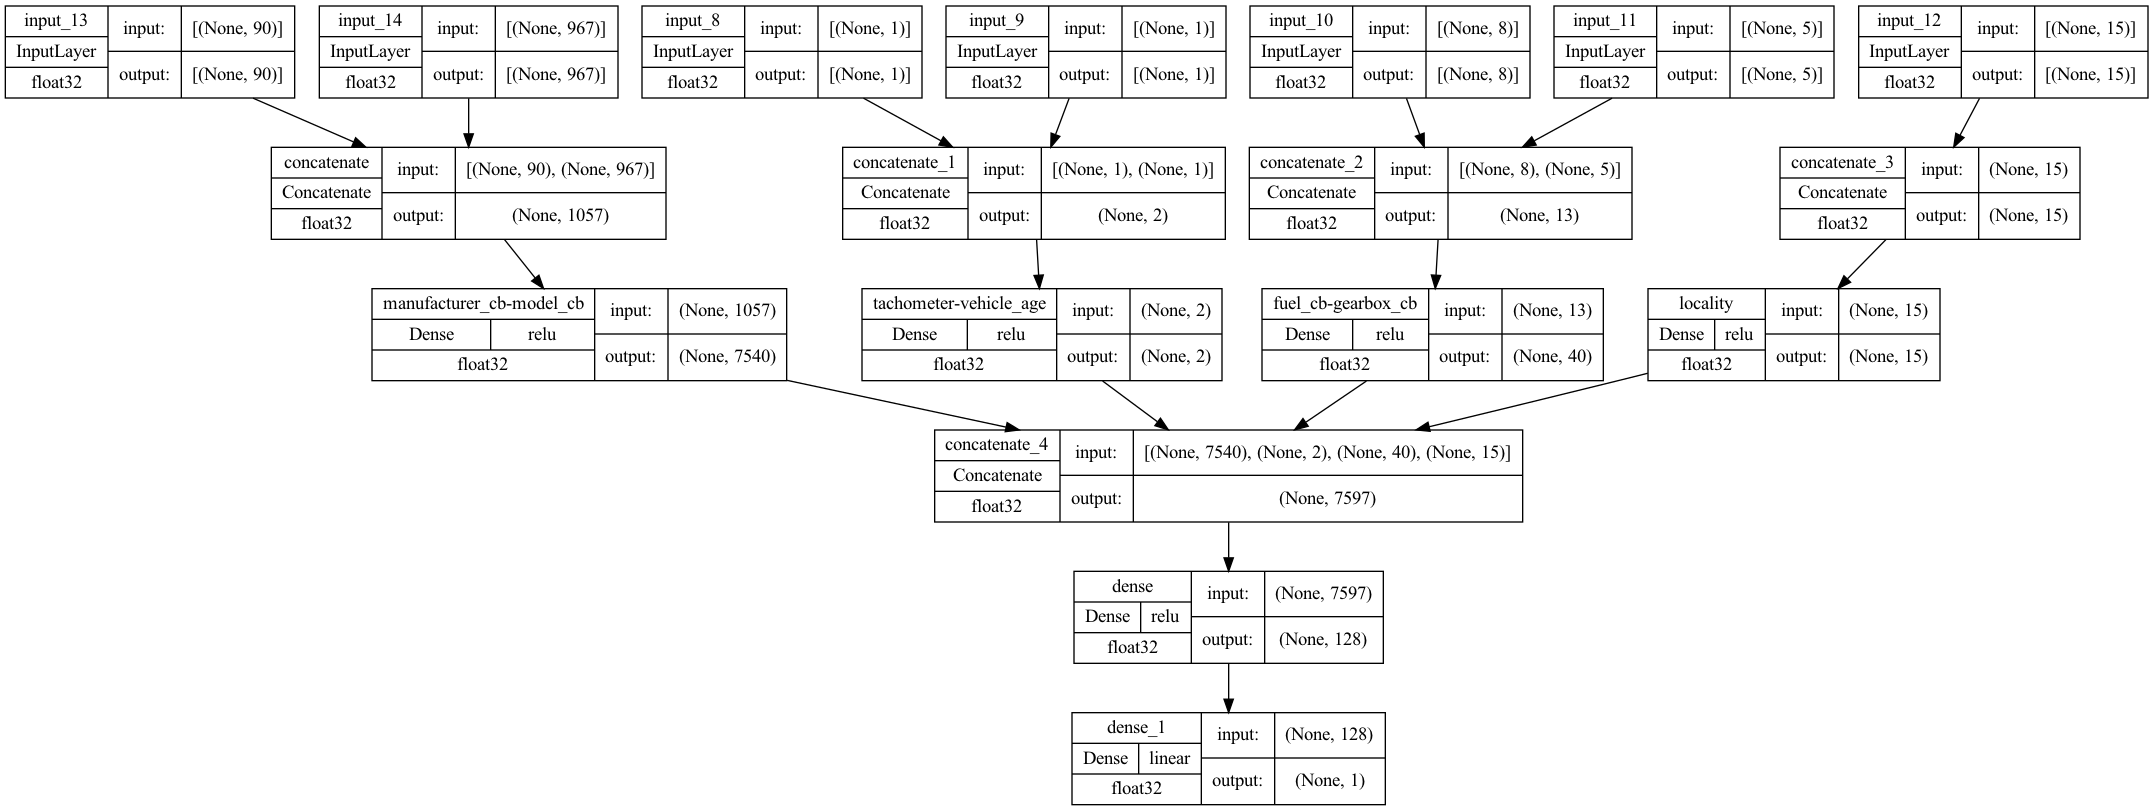

In [10]:
tf.keras.utils.plot_model(training_model, show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    expand_nested=True,
    show_layer_activations=True)

In [11]:
training_model.compile(
    optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.2),
    loss=tf.keras.losses.mean_absolute_error
)
history = training_model.fit(dataset, epochs=10, use_multiprocessing=True)

Epoch 1/10
    6/76319 [..............................] - ETA: 14:54 - loss: 476229.7188  

2022-09-29 18:59:36.961444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


76319/76319 [==============================] - 831s 11ms/step - loss: 132229.4375
Epoch 2/10
76319/76319 [==============================] - 829s 11ms/step - loss: 115290.5078
Epoch 3/10
76319/76319 [==============================] - 837s 11ms/step - loss: 110831.0469
Epoch 4/10
76319/76319 [==============================] - 851s 11ms/step - loss: 108597.3672
Epoch 5/10
76319/76319 [==============================] - 838s 11ms/step - loss: 107291.7500
Epoch 6/10
76319/76319 [==============================] - 849s 11ms/step - loss: 106436.6875
Epoch 7/10
76319/76319 [==============================] - 835s 11ms/step - loss: 105746.3125
Epoch 8/10
76319/76319 [==============================] - 843s 11ms/step - loss: 105172.0156
Epoch 9/10
76319/76319 [==============================] - 850s 11ms/step - loss: 104679.6250
Epoch 10/10
76319/76319 [==============================] - 849s 11ms/step - loss: 104289.1016


In [12]:
inputs = preprocessing_model.input
outputs = training_model(preprocessing_model(inputs))
inference_model = tf.keras.Model(inputs, outputs)

inputs_to_predict = train.drop(['price'], axis=1).head(2000).to_dict(orient="list")
predict_dataset = tf.data.Dataset.from_tensor_slices(inputs_to_predict).batch(1)
predictions = inference_model.predict(predict_dataset)

  23/2000 [..............................] - ETA: 9s

2022-09-29 21:19:50.462883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2000/2000 [==============================] - 9s 5ms/step


In [13]:
pd.options.display.float_format = '{:.0f}'.format

df_results = pd.DataFrame({"predicted": predictions.flatten(), "real": train.price.head(2000)})
df_results["diff"] = df_results.real - df_results.predicted
df_results["diff_abs"] = abs(df_results.real - df_results.predicted)
df_results["diff_abs_round"] = round(abs(df_results.real - df_results.predicted), -3)
df_results = df_results.merge(dataset_df, left_index=True, right_index=True).head(2000)
df_results.head(20)

,predicted,real,diff,diff_abs,diff_abs_round,fuel_cb,gearbox_cb,locality,manufacturer_cb,model_cb,price,tachometer,vehicle_age
0,1261321,1349000,87679,87679,88000,Nafta,Automatická,Středočeský kraj,BMW,Řada 3,1349000,26000,1
1,209518,455000,245482,245482,245000,Nafta,Manuální,Hlavní město Praha,BMW,Řada 3,455000,193107,5
2,1356999,1510000,153001,153001,153000,Nafta,None,Jihočeský kraj,BMW,Řada 3,1510000,12000,1
3,1263747,1228149,-35598,35598,36000,Nafta,Automatická,Královéhradecký kraj,BMW,Řada 3,1228149,25400,1
4,1339320,1703000,363680,363680,364000,Hybridní,Automatická,Moravskoslezský kraj,BMW,Řada 3,1703000,24000,1
5,1103538,1295000,191462,191462,191000,Nafta,Automatická,Moravskoslezský kraj,BMW,Řada 3,1295000,39000,2
6,82297,82000,-297,297,0,Benzín,Manuální,Středočeský kraj,BMW,Řada 3,82000,275808,19
7,1252557,1530650,278093,278093,278000,Nafta,None,Pardubický kraj,BMW,Řada 3,1530650,19000,1
8,192150,109000,-83150,83150,83000,Benzín,Manuální,Moravskoslezský kraj,BMW,Řada 3,109000,170600,16
9,1457169,1572999,115830,115830,116000,Nafta,Automatická,Hlavní město Praha,BMW,Řada 3,1572999,12000,1


In [14]:
# worst
df_results.sort_values(by='diff_abs_round', ascending=False).head(20)

,predicted,real,diff,diff_abs,diff_abs_round,fuel_cb,gearbox_cb,locality,manufacturer_cb,model_cb,price,tachometer,vehicle_age
1520,786762,6290000,5503238,5503238,5503000,Benzín,Automatická,Hlavní město Praha,Alfa Romeo,Giulia,6290000,10,0
781,6623618,2850000,-3773618,3773618,3774000,Benzín,Automatická,Hlavní město Praha,Ferrari,California,2850000,26000,11
780,7238116,3550000,-3688116,3688116,3688000,Benzín,Automatická,Olomoucký kraj,Ferrari,California,3550000,9780,11
782,6098693,2649000,-3449693,3449693,3450000,Benzín,Automatická,Hlavní město Praha,Ferrari,California,2649000,41568,10
670,2897834,6200000,3302166,3302166,3302000,Elektro,Automatická,Hlavní město Praha,Porsche,Taycan,6200000,50,2
779,5698583,2690000,-3008583,3008583,3009000,Benzín,Automatická,Středočeský kraj,Ferrari,California,2690000,53000,12
783,7139062,4190000,-2949062,2949062,2949000,Benzín,Automatická,Hlavní město Praha,Ferrari,California,4190000,13000,6
661,2506118,5242000,2735882,2735882,2736000,Elektro,Automatická,Středočeský kraj,Porsche,Taycan,5242000,12547,0
659,2913527,5115510,2201983,2201983,2202000,Elektro,Automatická,Hlavní město Praha,Porsche,Taycan,5115510,0,0
650,2260583,4355000,2094417,2094417,2094000,Elektro,Automatická,Středočeský kraj,Porsche,Taycan,4355000,22800,1


In [15]:
# best
df_results.sort_values(by='diff_abs_round', ascending=True).head(30)

,predicted,real,diff,diff_abs,diff_abs_round,fuel_cb,gearbox_cb,locality,manufacturer_cb,model_cb,price,tachometer,vehicle_age
1971,148718,149000,282,282,0,Nafta,Manuální,Jihomoravský kraj,BMW,Řada 3,149000,231946,12
163,55143,54999,-144,144,0,Nafta,Manuální,Královéhradecký kraj,Škoda,Fabia,54999,370000,14
345,546562,547000,438,438,0,Benzín,Automatická,Hlavní město Praha,Škoda,Karoq,547000,125847,4
194,95854,95999,145,145,0,Benzín,Manuální,Středočeský kraj,Škoda,Fabia,95999,186000,12
749,117558,118000,442,442,0,Nafta,Manuální,Hlavní město Praha,Volkswagen,Polo,118000,162404,15
1239,489469,489900,431,431,0,Nafta,Automatická,Hlavní město Praha,Volkswagen,Touareg,489900,190030,11
1760,135221,134900,-321,321,0,Benzín,Manuální,Moravskoslezský kraj,Citroën,C3,134900,94330,10
155,89591,89900,309,309,0,Benzín,Manuální,Pardubický kraj,Škoda,Fabia,89900,197242,14
6,82297,82000,-297,297,0,Benzín,Manuální,Středočeský kraj,BMW,Řada 3,82000,275808,19
290,689429,689900,471,471,0,Nafta,Automatická,Středočeský kraj,Škoda,Kodiaq,689900,140000,5


In [16]:
df_results.sort_values(by='diff_abs_round', ascending=True).to_html("res.html")

In [17]:
df_results.describe()

,predicted,real,diff,diff_abs,diff_abs_round,price,tachometer,vehicle_age
count,2000,2000,2000,2000,2000,2000,2000,2000
mean,719514,795980,76465,191252,191248,795980,90621,6
std,688167,808863,412258,373109,373111,808863,87758,6
min,36055,22000,-3773618,4,0,22000,0,0
25%,267069,250000,-63297,34847,35000,250000,14944,1
50%,526870,532000,10552,80603,81000,532000,65080,3
75%,905349,999900,105668,172602,173000,999900,149498,9
max,7238116,6290000,5503238,5503238,5503000,6290000,429282,41


In [23]:
df_results[df_results.diff_abs_round <= 20000].count()

predicted          320
real               320
diff               320
diff_abs           320
diff_abs_round     320
fuel_cb            320
gearbox_cb         315
locality           320
manufacturer_cb    320
model_cb           320
price              320
tachometer         320
vehicle_age        320
dtype: int64